# Import Lib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,  Activation, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os

# PATH

In [2]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Mounted at /content/drive/


In [3]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [5]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [6]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [7]:
n_observations = df.shape[0]
features = ["Open", "High", "Low", "Volume", "Adj Close"]

df = df[ features]
train = df[:int(n_observations*0.7)]
test = df[int(n_observations*0.7): int(n_observations*0.9)]
val = df[int(n_observations*0.9):]

# Helper Functions

In [8]:
def to_supervised(data, lookback = 3):
    n = data.shape[0]
    X, y = list(), list()
    for i in range(n - lookback):
        X.append(data[i: i + lookback])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

# Main Run

## Prepare data

In [9]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

train_X, train_y= to_supervised(train_scaled, 3)
test_X, test_y = to_supervised(test_scaled, 3)
val_X, val_y = to_supervised(val_scaled, 3)

## Seq2Seq Model

In [11]:
n_past = 3
n_features = 5
n_future = 1
layers = 1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))

encoder_cell = tf.keras.layers.LSTM(128, return_state=True, name='encoder_layer')

encoder_outputs_and_states = encoder_cell(encoder_inputs)

encoder_states = encoder_outputs_and_states[1:] # only keep the states

In [17]:
decoder_inputs = keras.layers.Input(shape=(None, 1), name='decoder_input') #### <=== must be 1


decoder_cell = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, name='decoder_layer')


decoder_outputs_and_states = decoder_cell(decoder_inputs, initial_state=encoder_states)

decoder_outputs = decoder_outputs_and_states[0] # only keep the output sequence
decoder_dense = keras.layers.Dense(1)

decoder_outputs = decoder_dense(decoder_outputs)

In [19]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', 
              loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 5)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        68608       ['input_2[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

## Train data

In [28]:
decoder_zero_inputs = np.zeros((train_X.shape[0], 1, 1))

history = model.fit([train_X, decoder_zero_inputs], train_y.reshape(-1, 1, 1), 
                    epochs=200,
                    batch_size=32)

Epoch 1/200
40/40 [==============================] - 1s 19ms/step - loss: 4.6469e-04
Epoch 2/200
40/40 [==============================] - 1s 18ms/step - loss: 4.0658e-04
Epoch 3/200
40/40 [==============================] - 1s 28ms/step - loss: 4.3891e-04
Epoch 4/200
40/40 [==============================] - 1s 25ms/step - loss: 3.9711e-04
Epoch 5/200
40/40 [==============================] - 1s 31ms/step - loss: 5.1106e-04
Epoch 6/200
40/40 [==============================] - 1s 33ms/step - loss: 4.1082e-04
Epoch 7/200
40/40 [==============================] - 1s 28ms/step - loss: 4.8123e-04
Epoch 8/200
40/40 [==============================] - 1s 18ms/step - loss: 4.1292e-04
Epoch 9/200
40/40 [==============================] - 0s 10ms/step - loss: 3.9800e-04
Epoch 10/200
40/40 [==============================] - 0s 11ms/step - loss: 4.3047e-04
Epoch 11/200
40/40 [==============================] - 0s 10ms/step - loss: 3.7221e-04
Epoch 12/200
40/40 [==============================] - 0s 10ms/s

## Test data

12/12 [==============================] - 0s 4ms/step


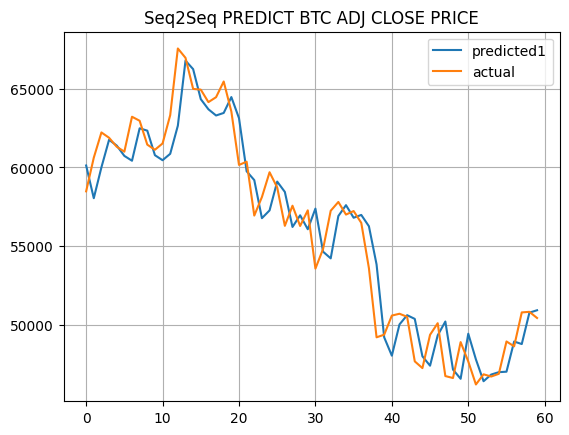

In [29]:
pred = model.predict([test_X, np.zeros((test_X.shape[0],1,1))])

days = 60

y_predicted1 = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )
# plot
plt.grid(True)
plt.plot(y_predicted1[:days], label="predicted1")
plt.plot(y_true[:days], label="actual")
plt.title("Seq2Seq PREDICT BTC ADJ CLOSE PRICE")
plt.legend()
plt.show()


# Evaluate


In [30]:
mae = mean_absolute_error(y_true, y_predicted1)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted1))
mape = mean_absolute_percentage_error(y_true, y_predicted1)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 876.6069036602208
RMSE: 1287.086819106615
mape: 0.025219790774413522


In [31]:
y_true[0]

58482.38672

In [32]:
y_predicted1[0]

60126.2